In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
from scipy.stats import *
from os.path import isfile, join
from os import listdir
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.utils import to_categorical
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
import seaborn as sn

In [2]:
def read_int(f):
    ba = bytearray(4)
    f.readinto(ba)
    prm = np.frombuffer(ba, dtype=np.int32)
    return prm[0]
    
def read_double(f):
    ba = bytearray(8)
    f.readinto(ba)
    prm = np.frombuffer(ba, dtype=np.double)
    return prm[0]

def read_double_tab(f, n):
    ba = bytearray(8*n)
    nr = f.readinto(ba)
    if nr != len(ba):
        return []
    else:
        prm = np.frombuffer(ba, dtype=np.double)
        return prm
    
def get_pics_from_file(filename):
    # Lecture du fichier d'infos + pics detectes (post-processing KeyFinder)
    #print("Ouverture du fichier de pics "+filename)
    f_pic = open(filename, "rb")
    info = dict()
    info["nb_pics"] = read_int(f_pic)
    #print("Nb pics par trame: " + str(info["nb_pics"]))
    info["freq_sampling_khz"] = read_double(f_pic)
    #print("Frequence d'echantillonnage: " + str(info["freq_sampling_khz"]) + " kHz")
    info["freq_trame_hz"] = read_double(f_pic)
    #print("Frequence trame: " + str(info["freq_trame_hz"]) + " Hz")
    info["freq_pic_khz"] = read_double(f_pic)
    #print("Frequence pic: " + str(info["freq_pic_khz"]) + " kHz")
    info["norm_fact"] = read_double(f_pic)
    #print("Facteur de normalisation: " + str(info["norm_fact"]))
    tab_pics = []
    pics = read_double_tab(f_pic, info["nb_pics"])
    nb_trames = 1
    while len(pics) > 0:
        nb_trames = nb_trames+1
        tab_pics.append(pics)
        pics = read_double_tab(f_pic, info["nb_pics"])
    #print("Nb trames: " + str(nb_trames))
    f_pic.close()
    return tab_pics, info

def create_y_dumies(path):
    files = [f for f in listdir(path) if isfile(join(path, f))] # on génère la liste des noms de fichiers
    files.remove('pics_LOGINMDP.bin')   # on enlève celui qu'on veut tester
    filesoutput = []
    for f in files: 
        f = f.replace('.bin', '').replace('pics','')
        files_output.append(f)
    y = pd.DataFrame(files_output)
    y = pd.get_dummies(files_output)
    y.columns = files_output
    return y

In [3]:
chemin = 'data/'

In [4]:
filenames = [chemin + f for f in listdir(chemin) if isfile(join(chemin, f))]
filenames.remove("data/pics_LOGINMDP.bin")

files = [f for f in listdir(chemin) if isfile(join(chemin, f))]
files.remove('pics_LOGINMDP.bin')

dico = {}
for i,file in enumerate(files):
    f = files[i].replace('.bin', '').replace('pics_','')
    dico[f]= i

inv_dico={}
for key, values in dico.items():
    inv_dico[values]=key

In [5]:
files

['pics_0.bin',
 'pics_1.bin',
 'pics_2.bin',
 'pics_3.bin',
 'pics_4.bin',
 'pics_5.bin',
 'pics_6.bin',
 'pics_7.bin',
 'pics_8.bin',
 'pics_9.bin',
 'pics_A.bin',
 'pics_B.bin',
 'pics_C.bin',
 'pics_CTRL.bin',
 'pics_D.bin',
 'pics_E.bin',
 'pics_ENTER.bin',
 'pics_F.bin',
 'pics_G.bin',
 'pics_H.bin',
 'pics_I.bin',
 'pics_J.bin',
 'pics_K.bin',
 'pics_L.bin',
 'pics_M.bin',
 'pics_N.bin',
 'pics_NOKEY.bin',
 'pics_O.bin',
 'pics_P.bin',
 'pics_Q.bin',
 'pics_R.bin',
 'pics_S.bin',
 'pics_SHIFT.bin',
 'pics_SPACE.bin',
 'pics_SUPPR.bin',
 'pics_T.bin',
 'pics_U.bin',
 'pics_V.bin',
 'pics_W.bin',
 'pics_X.bin',
 'pics_Y.bin',
 'pics_Z.bin',
 'read_pics.py']

In [6]:
data= []
for i, filename in enumerate(filenames):
    f = files[i].replace('.bin', '').replace('pics_','')
    tmp,info = get_pics_from_file(filename)
    if i == 0:
        df= pd.DataFrame(tmp)
        df['Y'] = dico[f]
    else:
        tmp_df = pd.DataFrame(tmp)
        tmp_df['Y'] = dico[f]
        df = df.append(tmp_df)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X = X.to_numpy()
y = y.to_numpy()
y = to_categorical(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

In [8]:
#X_train = MinMaxScaler().fit_transform(X_train)
#X = RobustScaler().fit_transform(X)
X_train = StandardScaler().fit_transform(X_train)


#X_test = MinMaxScaler().fit_transform(X_test)
#X_test = RobustScaler().fit_transform(X_test)
X_test = StandardScaler().fit_transform(X_test)

print(y_train.shape)
print(X_train.shape)
print(y.shape)
print(X.shape)

In [10]:
model = keras.Sequential(
    [
        keras.layers.Dense(256,activation="sigmoid", input_shape=(X_train.shape[-1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(128,activation="sigmoid"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64,activation="sigmoid"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(units=y_train.shape[-1], activation="softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4608      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                2

In [11]:
loss_cc = keras.losses.CategoricalCrossentropy()
model.compile(optimizer=keras.optimizers.Adam(
                   learning_rate=0.01,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07,
                    amsgrad=False,
                    name="Adam"), 
              loss=loss_cc)
my_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_loss",      # il vérifie la loss de validation
    min_delta=0,             # différence minimale de loss validation entre 2 itérations
    patience=10,              # si la loss remonte 3 itérations de suite, le NN s'arrête 
    verbose=0,               # quantité de commentaires donnés par keras pendant le process
    mode="auto",
    baseline=None,
    restore_best_weights=True)  # S'il a trop itéré et dépassé le val_loss optimal, il restore les poids correspondant
                                # à la val_loss optimale


history = model.fit(
    X_train,
    y_train,
    batch_size=8192,                    # Nombre de samples par batch
    epochs=500,                           # 500 itérations au maximum 
    verbose=2,                            # Quantité d'infos données lors du process
    callbacks=[my_callbacks],             # Définition des early stoppings définis au dessus
    validation_data=(X_test, y_test),       # Définition des validation data pour savoir si NN continue ou s'arrête
    )

Epoch 1/500
35/35 - 7s - loss: 1.6140 - val_loss: 3.9873
Epoch 2/500
35/35 - 4s - loss: 1.0905 - val_loss: 4.5809
Epoch 3/500
35/35 - 4s - loss: 1.0039 - val_loss: 4.5433
Epoch 4/500
35/35 - 4s - loss: 0.9728 - val_loss: 4.3630
Epoch 5/500
35/35 - 4s - loss: 0.9568 - val_loss: 4.2353
Epoch 6/500
35/35 - 4s - loss: 0.9463 - val_loss: 4.0910
Epoch 7/500
35/35 - 4s - loss: 0.9371 - val_loss: 3.8513
Epoch 8/500
35/35 - 4s - loss: 0.9329 - val_loss: 3.5682
Epoch 9/500
35/35 - 4s - loss: 0.9274 - val_loss: 3.2117
Epoch 10/500
35/35 - 4s - loss: 0.9257 - val_loss: 2.7915
Epoch 11/500
35/35 - 4s - loss: 0.9203 - val_loss: 2.4954
Epoch 12/500
35/35 - 4s - loss: 0.9171 - val_loss: 2.1616
Epoch 13/500
35/35 - 4s - loss: 0.9170 - val_loss: 1.9286
Epoch 14/500
35/35 - 4s - loss: 0.9122 - val_loss: 1.6843
Epoch 15/500
35/35 - 4s - loss: 0.9138 - val_loss: 1.5888
Epoch 16/500
35/35 - 4s - loss: 0.9098 - val_loss: 1.3633
Epoch 17/500
35/35 - 5s - loss: 0.9085 - val_loss: 1.3049
Epoch 18/500
35/35 - 5s

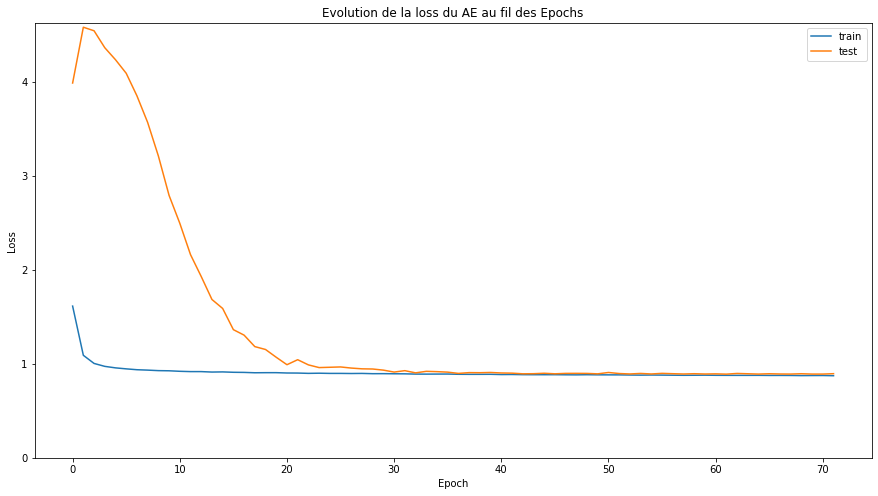

In [19]:

plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label ='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1.01*max(history.history['val_loss']))
# plt.ylim(0,0.4)
plt.legend()
plt.title('Evolution de la loss du AE au fil des Epochs')
plt.show()

In [20]:
y_pred = model.predict(X_test)
yp = np.argmax(y_pred,axis=1)
yt = np.argmax(y_test,axis=1)

In [21]:
bien_pred = 0
for i in range(len(yp)):
    if yp[i] == yt[i]:
        bien_pred += 1
print("%bien predicted = ", bien_pred/len(yp))  

%bien predicted =  0.5690030288810204


In [22]:
LGNMDP, _ = get_pics_from_file("data/pics_LOGINMDP.bin")
LGNMDP = pd.DataFrame(LGNMDP)
LGNMDP = LGNMDP.to_numpy()
lgnmdp_pred = model.predict(LGNMDP)


In [23]:
lgnmdp_pred_max = np.argmax(lgnmdp_pred,axis=1)
lgnmdp_pred_max

array([24, 26, 39, ..., 36, 36, 41], dtype=int64)

In [24]:
#dico

In [25]:
output = []

# fonction trouvée sur internet
def correspond_valeur_dico(v): 
    for k, val in dico.items(): 
        if v == val: 
            return k

for lgnmdpmax in lgnmdp_pred_max:
    tmp = correspond_valeur_dico(lgnmdpmax)
    output.append(tmp)

In [26]:
output

['M',
 'NOKEY',
 'X',
 'X',
 'M',
 'Z',
 'X',
 'Z',
 'M',
 'M',
 'Z',
 'M',
 'M',
 'NOKEY',
 'M',
 'R',
 'U',
 'M',
 'U',
 'Z',
 '2',
 '2',
 '2',
 'M',
 'X',
 'Z',
 'X',
 'M',
 'NOKEY',
 '2',
 'Z',
 'Z',
 '2',
 'U',
 'U',
 'Z',
 'Z',
 'M',
 'Z',
 'L',
 'M',
 'Z',
 'M',
 'Z',
 'M',
 'NOKEY',
 'M',
 'Z',
 'Z',
 'U',
 'U',
 'Z',
 'M',
 'M',
 'Z',
 'M',
 '2',
 'M',
 'U',
 'Z',
 'M',
 'M',
 'SUPPR',
 'M',
 'U',
 '2',
 'Z',
 'Z',
 'M',
 'M',
 'M',
 'M',
 'Z',
 '2',
 'X',
 'X',
 'M',
 'M',
 'M',
 'Z',
 '2',
 'Z',
 'Z',
 'M',
 'U',
 '2',
 'X',
 'U',
 'Z',
 'Z',
 'U',
 'M',
 'M',
 'M',
 'X',
 'Z',
 'U',
 'M',
 'U',
 'M',
 'M',
 'Z',
 'Z',
 'M',
 'U',
 'M',
 'Z',
 'M',
 'Z',
 'M',
 '2',
 'M',
 'U',
 'M',
 'M',
 'M',
 'U',
 'Z',
 'Z',
 'M',
 'M',
 'U',
 'M',
 'M',
 'Z',
 'Z',
 'X',
 '2',
 'X',
 'M',
 'Z',
 'Z',
 'M',
 'Z',
 'Z',
 'M',
 'U',
 'U',
 'Z',
 'M',
 '2',
 'X',
 'M',
 'M',
 'X',
 'M',
 'Z',
 'X',
 'U',
 'M',
 'M',
 '2',
 'M',
 'Z',
 'NOKEY',
 'Z',
 'Z',
 'M',
 'U',
 'U',
 'U',
 'M',
 'Z'